### Задача: проранжировать округа Москвы по усредненной стоимости аренды однушки. 

#### 1. Загрузим данные с циана

Снять 1-комнатную квартиру в Москве 54 страницы и почти 9 тысяч предложений
Прогружаем данные с сайта и сохраняем в файлы. С запасом возьмем 57 страниц.
Слегка замаскируемся под человека, добавив задержку при запросах и задав хедер, как будто этот "шустрый" человек ходит через браузере.
Не забываем каждый раз проверять ответ от сайта, а то вдруг нас раскрыли и уже забанили. 

Прежде чем мы начнем:
* добавим декораторы для оценки скоростей выполнения наших функций (ну просто исключительно ради спортивного интереса)
* ну и как же без логгирования?

In [ ]:
import time
import datetime

def timer(f):
    def wrap_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        delta = time.time() - start
        print (f'Время выполнения функции {f.__name__} составило {delta} секунд')
        return result
    return wrap_timer

In [ ]:
import logging
 
def log(f):
    
    def wrap_log(*args, **kwargs):
        
        logging.info(f"Запущена функция {f.__doc__}")
        result = f(*args, **kwargs)
        logging.info(f"Результат: {result}")
        return result
    
    return wrap_log

logging.basicConfig(level=logging.INFO)

P.S. В украшательстве можно пойти дальше и добавить "ползунок" с процентом готовности (например, с помощью библиотеки ```tqdm```). Сейчас код запросов на сайт закомментирован, нам же не нужно случайно начать все заново?

In [ ]:
import requests
import json
import time
import tqdm
import numpy as np


@timer
@log
def requests_site(N):
    """функция сбора данных с сайта"""
    headers = ({'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.5 Safari/605.1.15'})
    pages = [1 + i for i in range(N)]
    n = 0

    for i in pages:
        s = f"https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&page={i}&offer_type=flat&region=1&room1=1&type=-2"
            
        response = requests.get(s, headers = headers)
        if response.status_code == 200:
            name = f'sheets/sheet_{i}.txt'
            with open(name, 'w') as f:
                f.write(response.text)
            n += 1
            logging.info(f"Обработана страница {i}")
        else:
            print(f"От страницы {i} пришел ответ response.status_code = {response.status_code}")
        time.sleep(np.random.randint(7,13))
    return f"Успешно загружено {n} страниц"

requests_site(300)

#### 2. Соберем данные в единый датафрейм

Для скрапинга страниц на выбор ```BeautifulSoup``` и ```lxml```, так как задача у нас разовая и выбор оптимальных инструментов в эту задачу не входит, используем "прекрасный суп" просто за его прикольное название,
хотя, говорят, что ```lxml``` быстрее. Подробнее про сравнение библиотек можно почитать, например, [тут](https://habr.com/ru/post/280238/)
        

#### 2.1 Прочитаем файлы в единый список.

Можно сделать красиво, взять список файлов из папки с помощью библиотеки ```os```, отфильтровать нужные нам по расширению и пройтись по ним. Но мы сделаем проще, так как точное число файлов и точные их названия нам известны.

In [ ]:
def read_file(filename):
    with open(filename) as input_file:
        text = input_file.read()
    return text

In [ ]:
import tqdm

site_texts = []
pages = [1 + i for i in range(309)]
        
for i in tqdm.tqdm(pages):
    name = f'sheets/sheet_{i}.txt'
    site_texts.append(read_file(name))
    
print(f"Прочитано {len(site_texts)} файлов.")

#### 2.2 Распарсим странички 

In [ ]:
from bs4 import BeautifulSoup
import re
import pandas as pd
from dateutil.parser import parse
from datetime import datetime, date, time

def parse_tag(tag, tag_value, item):
    key = tag
    value = "None"
    if item.find('div', {'class': tag_value}):
        if key == 'link':
            value = item.find('div', {'class': tag_value}).find('a').get('href')
        elif (key == 'price' or key == 'price_meter'):
            value = parse_digits(item.find('div', {'class': tag_value}).text, key)
        elif key == 'pub_datetime':
            value = parse_date(item.find('div', {'class': tag_value}).text)
        else:
            value = item.find('div', {'class': tag_value}).text
    return key, value


def parse_digits(string, type_digit):
    digit = 0
    try:
        if type_digit == 'flats_counts':
            digit = int(re.sub(r" ", "", string[:string.find("пр")]))
        elif type_digit == 'price':
            digit = re.sub(r" ", "", re.sub(r"₽", "", string))
        elif type_digit == 'price_meter':
            digit = re.sub(r" ", "", re.sub(r"₽/м²", "", string))
    except:
        return -1
    return digit


def parse_date(string):
    now = datetime.strptime("15.03.20 00:00", "%d.%m.%y %H:%M")
    s = string
    if string.find('сегодня') >= 0:
        s = "{} {}".format(now.day, now.strftime("%b"))
        s = string.replace('сегодня', s)
    elif string.find('вчера') >= 0:
        s = "{} {}".format(now.day - 1, now.strftime("%b"))
        s = string.replace('вчера',s) 
    if (s.find('мар') > 0):
        s = s.replace('мар','mar')
    if (s.find('фев') > 0):
        s = s.replace('фев','feb')
    if (s.find('янв') > 0):
        s = s.replace('янв','jan')
    return parse(s).strftime('%Y-%m-%d %H:%M:%S')
    
    
def parse_text(text, index):
    
    tag_table = '_93444fe79c--wrapper--E9jWb'
    tag_items = ['_93444fe79c--card--_yguQ', '_93444fe79c--card--_yguQ']
    tag_flats_counts = '_93444fe79c--totalOffers--22-FL'
    tags = {
        'link':('c6e8ba5398--info-section--Sfnx- c6e8ba5398--main-info--oWcMk','undefined c6e8ba5398--main-info--oWcMk'),
        'desc': ('c6e8ba5398--title--2CW78','c6e8ba5398--single_title--22TGT', 'c6e8ba5398--subtitle--UTwbQ'),
        'price': ('c6e8ba5398--header--1df-X', 'c6e8ba5398--header--1dF9r'),
        'price_meter': 'c6e8ba5398--term--3kvtJ',
        'metro': 'c6e8ba5398--underground-name--1efZ3',
        'pub_datetime': 'c6e8ba5398--absolute--9uFLj',
        'address': 'c6e8ba5398--address-links--1tfGW',
        'square': ''
    }
    
    res = []
    flats_counts = 0
    soup = BeautifulSoup(text)  
    if soup.find('div', {'class': tag_flats_counts}):
        flats_counts = parse_digits(soup.find('div', {'class': tag_flats_counts}).text, 'flats_counts')
   
    flats_list = soup.find('div', {'class': tag_table}) 
    if flats_list:
        items = flats_list.find_all('div', {'class': tag_items})         
        for i, item in enumerate(items):
            
            d = {'index': index}
            index += 1
            for tag in tags.keys():
                tag_value = tags[tag]
                key, value = parse_tag(tag, tag_value, item)
                d[key] = value
            results[index] = d
        
    return flats_counts, index

Интересным ньюансом оказалось то, что цифра, указанная сверху страницы и обозначающая общее количество квартир, найденных по запросу, отличается от страницы к странице. Так, в нашем примере это <span style="color:gray">*5 402 предложение отсортированы по умолчанию*</span> находится в диапазоне <span style="color:gray">*от 5343 до 5402*</span>, постепенно снижаясь с увеличением номера страницы запроса (но не на количество отображенных объявлений). К тому же оказалось возможным продолжать выгружать страницы за пределами ограничения в количестве страниц, указанных на сайте. В нашем случае на сайте было предложено всего 54 страницы, но мы смогли выгрузить 309 страниц, только с более старыми объявлениями, итого 8640 объявлений об аренде квартир.
Расследование данного факта оставим за рамками данной статьи.

In [ ]:
from IPython.display import clear_output

sum_flats = 0
index = 0
results = {}
for i, text in enumerate(site_texts):
    flats_counts, index = parse_text(text, index)    
    sum_flats = len(results)
    clear_output(wait=True)
    print(f" Файл {i + 1} flats = {flats_counts}, добавлено итого {sum_flats} квартир")
print(f"Итого sum_flats ({sum_flats}) = flats_counts({flats_counts})")

#### 2.3 Cоберем целостный красивый датафрейм.

In [ ]:
col = {'index','link','desc','price','price_meter', 'address', 'metro','pub_datetime'}
df = pd.DataFrame(results, col).T.sort_values(by="pub_datetime", ascending = True)
df.to_csv('flats.csv')

#### 3 Обработаем наш датафрейм

Итак, имеем красивый датафрейм с 8640 объявлениями. Обработаем "сырые" данные.

Проведем поверхностный анализ средних и медианных цен по округам, посчитаем среднюю стоимость аренды квадратного метра квартиры и стоимость квартиры в округе "в среднем".

Будем исходить из следующих допущений для нашего исследования:

1. Отсутствие повторов: все найденные квартиры - действительно существующие квартиры. На первом этапе повторяющиеся квартиры по адресу и по квадратуре мы отсеяли, но если у квартиры немного разная квадратура или адрес - такие варианты считаем разными квартирами.


2. Средняя квартира в округе - квартира со средней квадратурой для округа.
Сейчас можно уйти в глубокие обсуждения - что считать "средней" квартирой в округе? Можно закопаться (и это будет правильно) в параметрах каждой найденной квартиры и найди средние значения таких показателей, как площадь, этаж, близость к метро, смежность или раздельность комнат и сан. узла, наличие лоджии или балкона, качество ремонта, год и тип постройки дома и многие другие показатели. Оставим это на будущие "изыскания" и остановимся на определении: среднюю квартиру в округе будем считать по средней квадратуре. А чтобы исключительные варианты или "выбросы" (единичные квартиры с непривычно большим метражом или с неожиданной низкой стоимостью) не изкажали наш результат, определим их и удалим из исследования.

Нам понадобятся:
price_per_month - цена за месяц ареды в рублях
square - площадь
okrug - округ, в данном исследовании весь адрес нам не интересен
price_meter - цена аренды за 1 кв метр


In [1]:
import pandas as pd

df = pd.read_csv('flats.csv')
df.shape

(8640, 9)

In [2]:
df['price_per_month'] = df['price'].str.strip('/мес.').astype(int) #price_int
new_desc = df["desc"].str.split(",", n = 3, expand = True) 
df["square"]= new_desc[1].str.strip(' м²').astype(int)
df["floor"]= new_desc[2]
new_address = df['address'].str.split(',', n = 3, expand = True)
df['okrug'] = new_address[1].str.strip(" ")
df['price_per_meter'] = (df['price_per_month'] / df['square']).round(2) #price_std

df = df.drop(['index','metro', 'price_meter','link', 'price','desc','address','pub_datetime','floor'], axis='columns')

Теперь "займемся" выбросами вручную по графикам. Для визуализации данных посмотрим три библиотеки: ```matplotlib```, ```seaborn``` и ```plotly```. 

1. Гистограммы данных. Matplotlib позволяет просто и быстро отобразить все диаграммы по интересующим нас группам данных, большего нам и не надо. Рисунок ниже, по которому всего 1 предложение в Митино не могут служить качественной оценкой средней квартиры, удалим. Еще интересная картира в ЮАО: большинство предложений (более 500 шт) с арендной стоимостью ниже 1000 руб., и всплеск предложений (почти 300 шт) на 1700 руб за квадратный метр. В дальнейшем можно посмотреть почему так происходит - покопавшись в других показателях по этим квартирам.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11686d550>,
      dtype=object)

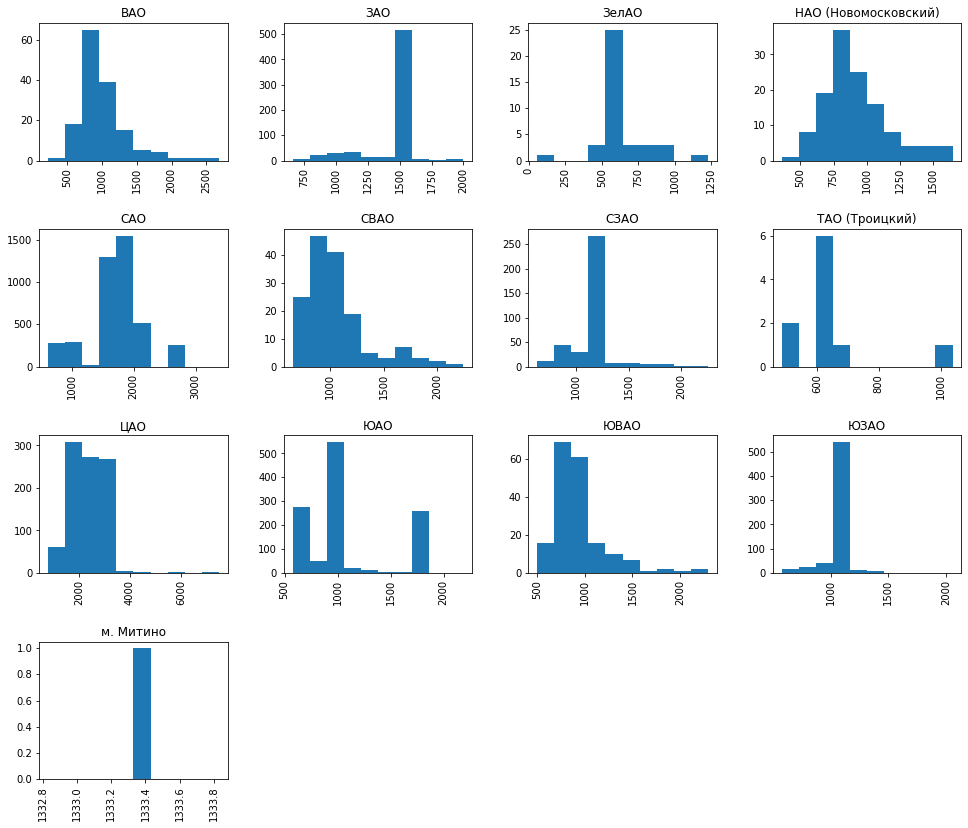

In [7]:
import matplotlib
hists = df['price_per_meter'].hist(by=df['okrug'], figsize=(16, 14), color = "tab:blue", grid = True)
hists

In [8]:
df_copy = df.copy(deep = True)
#1 удаляем Митино, так как одно значение не показательно
df_copy.drop(df_copy[df_copy['okrug'] == 'м. Митино'].index, inplace=True)



2. Разброс значений. Ниже представила графики с помощью всех трех библиотек. ```seaborn``` по умолчанию - более красивая и яркая, зато ```plotly``` позволяет сразу отображать значения при наведении мышки, что нам очень удобно для выбора значений "выбросов", которые мы будем удалять. 

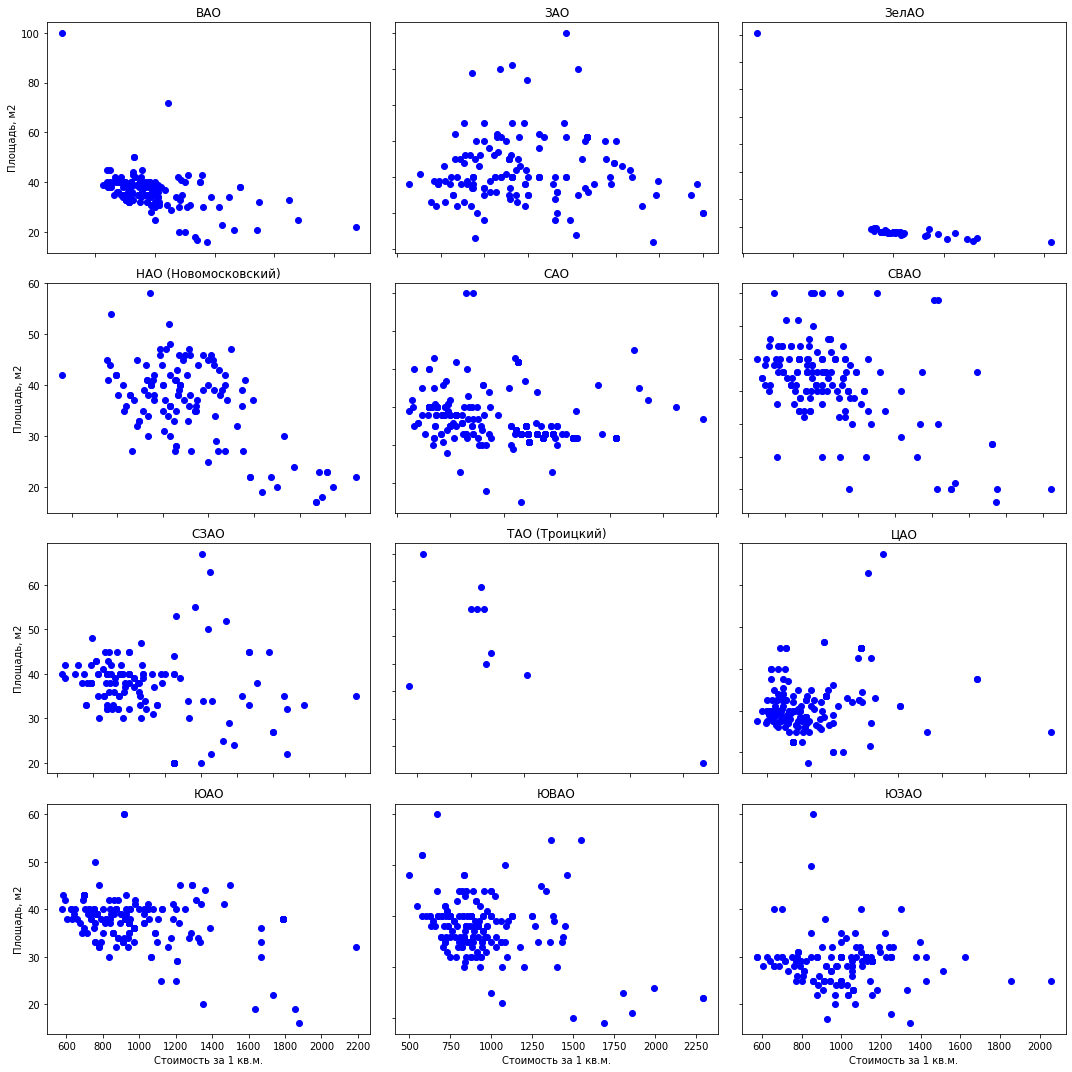

In [9]:
import matplotlib 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(15,15))

for i, (name, group) in enumerate(df_copy.groupby('okrug')):
    axes = axes.flatten()
    axes[i].scatter(group['price_per_meter'],group['square'], color ='blue')
    axes[i].set_title(name)
    axes[i].set(xlabel='Стоимость за 1 кв.м.', ylabel='Площадь, м2')
    axes[i].label_outer()
    
fig.tight_layout()  

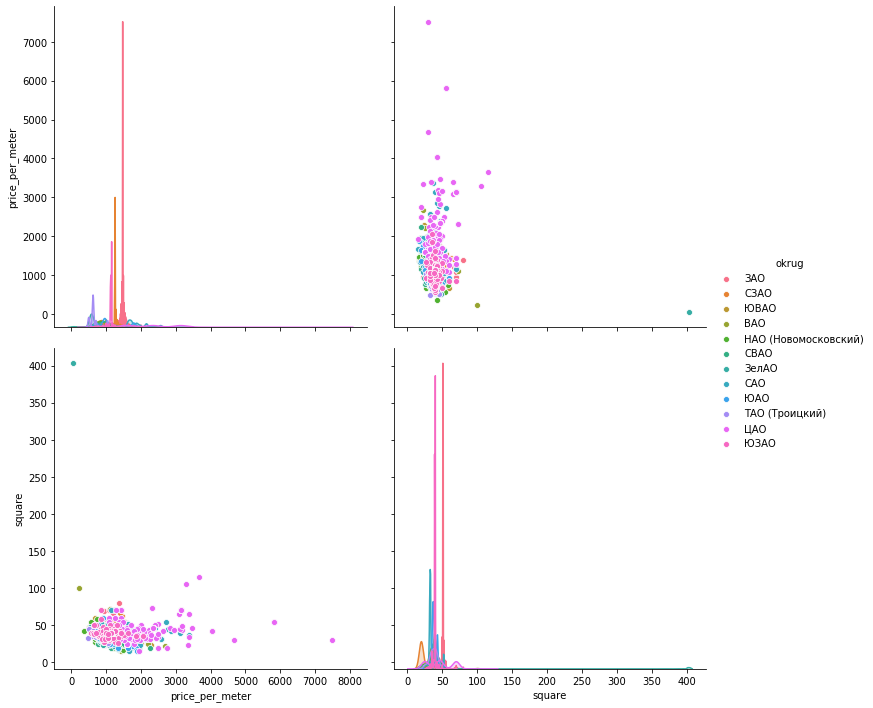

In [10]:
import seaborn as sns
sns.pairplot(vars=["price_per_meter","square"], data=df_copy, hue="okrug", height=5)

In [11]:
import plotly.express as px

for i, (name, group) in enumerate(df_copy.groupby('okrug')):
    fig = px.scatter(group, x="price_per_meter", y="square", facet_col="okrug",
                 width=400, height=400)
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [12]:
indexes = []

indexes.append(df_copy[(df_copy['okrug'] == 'САО')&(df_copy['price_per_meter'] == 1142.86)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'САО')&(df_copy['price_per_meter'] == 1214.29)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЗелАО')&(df_copy['price_per_meter'] == 57.07)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЗелАО')&(df_copy['price_per_meter'] == 1227.27)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЗАО')&(df_copy['price_per_meter'] == 1375)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ВАО')&(df_copy['price_per_meter'] == 220)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ВАО')&(df_copy['price_per_meter'] == 1111.11)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ВАО')&(df_copy['price_per_meter'] == 2681.82)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЦАО')&(df_copy['price_per_meter'] == 3301.89)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЦАО')&(df_copy['price_per_meter'] == 3684.21)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЦАО')&(df_copy['price_per_meter'] == 7500)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'СЗАО')&(df_copy['price_per_meter'] == 1405.61)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'СЗАО')&(df_copy['price_per_meter'] == 1449.21)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'СЗАО')&(df_copy['price_per_meter'] == 2257.14)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЮВАО')&(df_copy['price_per_meter'] == 2291.67)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЮВАО')&(df_copy['price_per_meter'] == 666.67)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЮАО')&(df_copy['price_per_meter'] == 916.67)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЮАО')&(df_copy['price_per_meter'] == 2666.67)].index)

indexes.append(df_copy[(df_copy['okrug'] == 'ЮЗАО')&(df_copy['price_per_meter'] == 857.14)].index)
indexes.append(df_copy[(df_copy['okrug'] == 'ЮЗАО')&(df_copy['price_per_meter'] == 2057.14)].index)

print(len(indexes))
print(indexes)


20
[Int64Index([5208], dtype='int64'), Int64Index([3955], dtype='int64'), Int64Index([148], dtype='int64'), Int64Index([243], dtype='int64'), Int64Index([54, 244, 5813], dtype='int64'), Int64Index([1244], dtype='int64'), Int64Index([3657], dtype='int64'), Int64Index([2834], dtype='int64'), Int64Index([1249], dtype='int64'), Int64Index([], dtype='int64'), Int64Index([1242], dtype='int64'), Int64Index([7685], dtype='int64'), Int64Index([7428], dtype='int64'), Int64Index([5515], dtype='int64'), Int64Index([1695, 2526], dtype='int64'), Int64Index([1586, 6099], dtype='int64'), Int64Index([17, 1649], dtype='int64'), Int64Index([], dtype='int64'), Int64Index([430, 3981, 4524], dtype='int64'), Int64Index([5193], dtype='int64')]


In [13]:
for index in indexes:
    df_copy.drop(index, inplace=True)


In [14]:
df_copy.to_csv('flats_clear_data.csv')
df_copy.head(5)

Unnamed: 0  price_per_month  square okrug  price_per_meter
0        1381            60000      30   ЗАО          2000.00
1        1174            65000      35  СЗАО          1857.14
2        1142            32000      33  ЮВАО           969.70
3        1390            80000      71   ЗАО          1126.76
4        1350            48000      50   ЗАО           960.00

4. Анализ данных

Итак, имеем датафрейм с очищенными данными. Всего 8602 предложения. Проведем расчеты и посмотрим на усредненные и на медианные данные.


In [15]:
import pandas as pd

df_clear = pd.read_csv('flats_clear_data.csv')
df_clear.shape

(8614, 6)

In [16]:
df_counts = df_clear['okrug'].value_counts().to_frame().reset_index()
df_counts.rename(columns={'index': 'okrug', 'okrug': 'counts'}, inplace=True)

df_means = df_clear.groupby(['okrug']).agg({'price_per_meter': 'mean', 'price_per_month': 'mean', 'square': 'mean'}).round(2)
df_means.rename(columns={'price_per_meter': 'mprice_per_meter', 'price_per_month': 'mprice_per_month', 'square': 'msquare'}, inplace=True)

df_result = pd.merge(df_counts, df_means, on='okrug')
df_result['price_mean'] = df_result['mprice_per_meter'] * df_result['msquare']
df_result['price_mean'] = df_result['price_mean'].round(2)

df_medians = df_clear.groupby(['okrug']).agg({'price_per_meter': 'median'}).round(2)
df_medians.rename(columns={'price_per_meter': 'medprice_per_meter'}, inplace=True)
df_result = pd.merge(df_result, df_medians, on='okrug')

df_std = df_clear.groupby(['okrug']).agg({'price_per_meter': 'std'}).round(2)
df_std.rename(columns={'price_per_meter': 'stdprice_per_meter'}, inplace=True)
df_result = pd.merge(df_result, df_std, on='okrug')


df_result = df_result.sort_values(['price_mean'], ascending=False)
df_result.to_csv('flats_results.csv')

df_result_copy = df_result.copy(deep = True)
df_result_copy.rename(columns={'okrug': 'Округ', 
                          'counts': 'Количество предложений',
                          'mprice_per_meter': 'Средняя цена за 1 кв.м.',
                          'mprice_per_month': 'Средняя цена за месяц аренды',
                          'msquare': 'Средняя площадь',
                          'price_mean': 'Цена в среднем',
                          'medprice_per_meter': 'Медианная цена за 1 кв.м.',
                          'stdprice_per_meter': 'Стандартное отклонение цены за 1 кв.м.'
                         }, inplace=True)

df_result_copy 

Округ  Количество предложений  Средняя цена за 1 кв.м.  \
2                    ЦАО                     915                  2273.81   
3                    ЗАО                     647                  1405.16   
0                    САО                    4217                  1739.16   
4                   ЮЗАО                     637                  1109.01   
1                    ЮАО                    1167                  1085.82   
7                   СВАО                     153                  1050.49   
6                   ЮВАО                     181                   927.62   
8                    ВАО                     147                   977.97   
9   НАО (Новомосковский)                     126                   915.11   
5                   СЗАО                     377                  1194.02   
10                 ЗелАО                      37                   637.35   
11        ТАО (Троицкий)                      10                   646.43   

    Средняя цена за месяц аренды  Средняя площадь  Цена в среднем  \
2                      115901.14            46.41       105527.52   
3                       69236.55            48.95        68782.58   
0                       59647.94            34.82        60557.55   
4                       43568.27            39.29        43573.00   
1                       41171.70            38.29        41576.05   
7                       37374.35            36.47        38311.37   
6                       34697.08            37.80        35064.04   
8                       34135.83            35.71        34923.31   
9                       32445.15            36.71        33593.69   
5                       29859.87            25.69        30674.37   
10                      24162.11            38.62        24614.46   
11                      23450.00            37.10        23982.55   

    Медианная цена за 1 кв.м.  Стандартное отклонение цены за 1 кв.м.  
2                     2340.43                                  699.94  
3                     1470.59                                  182.11  
0                     1727.27                                  409.03  
4                     1125.00                                  115.37  
1                      945.95                                  399.59  
7                      975.61                                  294.54  
6                      875.00                                  242.25  
8                      921.05                                  297.91  
9                      869.00                                  238.80  
5                     1250.00                                  192.21  
10                     600.00                                  116.24  
11                     622.02                                  151.49

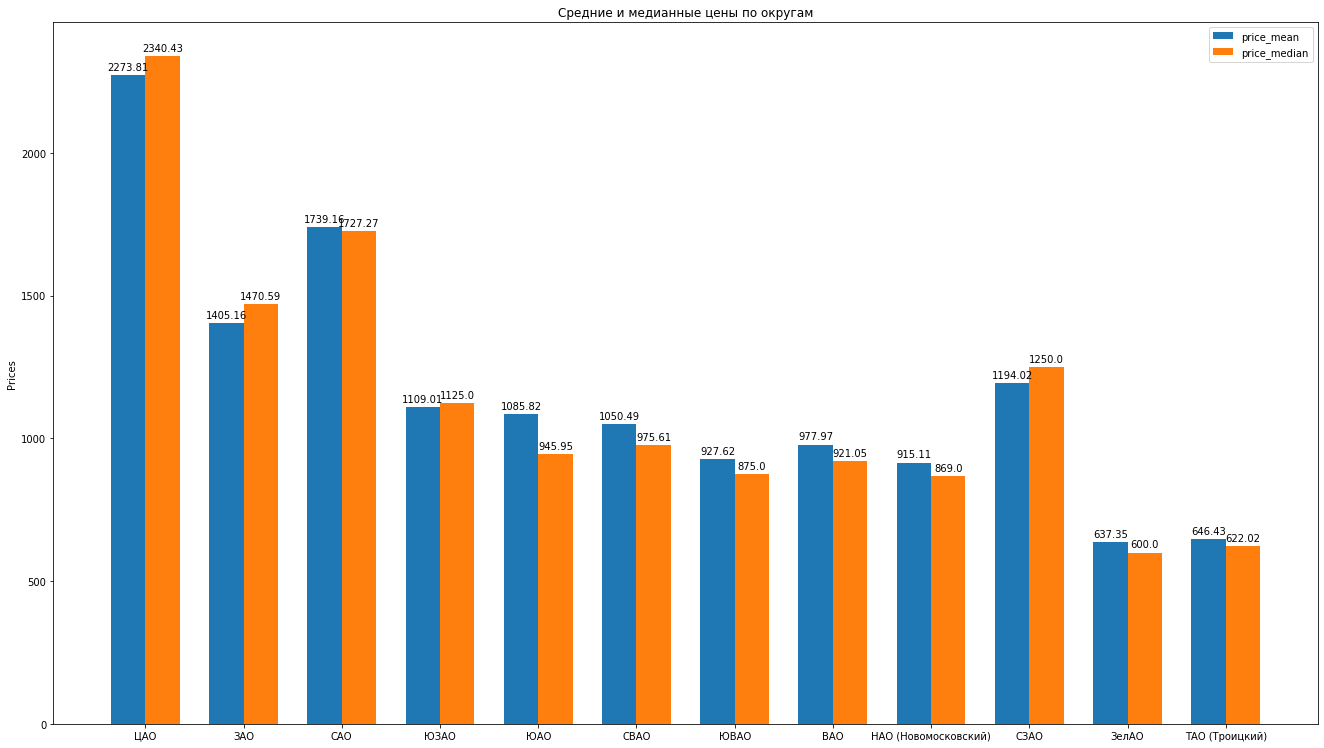

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = df_result['okrug']
price_mean = df_result['mprice_per_meter']
price_median = df_result['medprice_per_meter']

x = np.arange(len(labels))  
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, price_mean, width, label='price_mean')
rects2 = ax.bar(x + width/2, price_median, width, label='price_median')

ax.set_ylabel('Prices')
ax.set_title('Средние и медианные цены по округам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.set_size_inches(18.5, 10.5, forward=True) 

fig.tight_layout()

plt.show()

Что можно еще сказать про структуру предложений по аренде квартир на основе данных: 

* В ЦАО, ЗАО квартиры несколько переоценены, так как средние цены на квартиры выше, чем цена на аренду в среднем. Это некий введеный нами “индекс” стоимости аренды квартиры в округе, стоимость средней квартиры по средней цене в округе (средняя квадратура в округе на среднюю цену в округе). Следует заменить, что это тренировочное упражнение и в бою, конечно же, следует гораздо ответственнее и сложнее отнестись к созданию индекса цены, возможно, следует ввести много других параметров, от которых будет зависеть “эталонная” цена аренды. А вот в ВАО и НАО, например, цены слегка занижены.

* Медианные цены тоже представляют достаточно интересную информацию. Среднее значение в целом довольно чувствительно к выбрасам. Это как в анекдотах про «среднюю температуру по больнице». В интернете много статей на простом языке объясняющих разницу между данными статистическими показателями, например «Средние» значения — ваш враг. Как не попасться на удочку усреднения. Медиана же более устойчива к выбросам и позволяет более точно характеризовать предложения. Так, в ЮАО и СВАО, например, медианная цена аренды достаточно ниже, чем средняя цена, а это значит все-таки такая более низкая, чем средняя, цена будет более точно описывать ситуацию с рынком аренды в округе. См. гистограмму.

* Стандартное отклонение характеризует меру разброса значений предложений, насколько “густо” сосредоточены точки, насколько цены колеблются от среднего. Видим, что наибольший разбор у нас в ЦАО, а наименьший — в ЮЗАО и ЗелАО.


6. Геоданные

Отдельной, невероятно интересной и красивой главой идет тема геоданные, отображение наших данных в привязке к карте. Очень подробно и детально можно посмотреть например [тут](https://habr.com/ru/company/ods/blog/338554/), [тут](https://habrahabr.ru/post/235283/) и [тут](https://habrahabr.ru/post/270513/)

Кратко, ```OpenStreetMap``` наше все, удобные инструменты это: ```geopandas```, ```cartoframes``` (говорят, он уже погиб?) и ```folium```, который мы и будем использовать :) 
Вот как будут выглядеть наши данные на карте.

In [18]:
import folium
import geopandas 
import pandas as pd
import json

mo_df = geopandas.GeoDataFrame.from_file('atd/mo.shp')
gjson = mo_df.to_json()

df_result.okrug.replace('НАО (Новомосковский)','Новомосковский', inplace=True) 
df_result.okrug.replace('ТАО (Троицкий)','Троицкий', inplace=True) 


full_df = pd.merge(left=mo_df, right=df_result, left_on='ABBREV_AO', right_on='okrug')
full_gf = geopandas.GeoDataFrame(full_df)
df_result.head(15)

okrug  counts  mprice_per_meter  mprice_per_month  msquare  \
2              ЦАО     915           2273.81         115901.14    46.41   
3              ЗАО     647           1405.16          69236.55    48.95   
0              САО    4217           1739.16          59647.94    34.82   
4             ЮЗАО     637           1109.01          43568.27    39.29   
1              ЮАО    1167           1085.82          41171.70    38.29   
7             СВАО     153           1050.49          37374.35    36.47   
6             ЮВАО     181            927.62          34697.08    37.80   
8              ВАО     147            977.97          34135.83    35.71   
9   Новомосковский     126            915.11          32445.15    36.71   
5             СЗАО     377           1194.02          29859.87    25.69   
10           ЗелАО      37            637.35          24162.11    38.62   
11        Троицкий      10            646.43          23450.00    37.10   

    price_mean  medprice_per_meter  stdprice_per_meter  
2    105527.52             2340.43              699.94  
3     68782.58             1470.59              182.11  
0     60557.55             1727.27              409.03  
4     43573.00             1125.00              115.37  
1     41576.05              945.95              399.59  
7     38311.37              975.61              294.54  
6     35064.04              875.00              242.25  
8     34923.31              921.05              297.91  
9     33593.69              869.00              238.80  
5     30674.37             1250.00              192.21  
10    24614.46              600.00              116.24  
11    23982.55              622.02              151.49

In [19]:
y = json.loads(gjson)
list_names = []
dict_coordinates = dict()

for mo in y['features']:
    name = mo['properties']['ABBREV_AO']
    
    if name not in list_names:
        list_names.append(name)
        if (len(df_result[df_result['okrug'] == name]['price_mean']) != 0):
            vote = df_result[df_result['okrug'] == name]['price_mean'].values[0]
            x = mo['geometry']['coordinates'][0][0][1]
            y = mo['geometry']['coordinates'][0][0][0]
            dict_coordinates[name] = (y,x) 
print(dict_coordinates)

#координаты маркеров
dict_coordinates2 = {'Троицкий': ('Troitskii',37.1031012, 55.3408329),
 'ЗАО': ('ZAO',37.4276499, 55.7482092),
 'Новомосковский': ('NewMoscow',37.4315575, 55.5203129),
 'ЗелАО': ('ZelAO',37.1685294, 55.98000),
 'СЗАО': ('SZAO',37.4461022, 55.7944941),
 'ЮАО': ('UAO',37.6534248, 55.65539),
 'САО': ('SAO',37.4962542, 55.8524795),
 'ЮЗАО': ('UZAO',37.5395575, 55.6273129),
 'ЦАО': ('CAO',37.6139298, 55.7584219),
 'СВАО': ('SVAO',37.5194795, 55.9417633),
 'ВАО': ('VAO',37.7103095, 55.8029193),
 'ЮВАО': ('UVAO',37.6606903, 55.7307034)}

{'Троицкий': ([36.8031012, 55.4408329], [36.8031903, 55.4416007]), 'ЗАО': (37.4276499, 55.7482092), 'Новомосковский': (37.4395575, 55.6273129), 'ЗелАО': (37.1785294, 56.0079518), 'СЗАО': (37.4461022, 55.7944941), 'ЮАО': (37.6534248, 55.65539), 'САО': (37.4962542, 55.8924795), 'ЮЗАО': (37.4557187, 55.6370488), 'ЦАО': (37.5139298, 55.7584219), 'СВАО': (37.5194795, 55.9417633), 'ВАО': (37.6503095, 55.7929193), 'ЮВАО': (37.6606903, 55.7307034)}


In [20]:
import json
from folium import FeatureGroup, Marker, LayerControl

def popform(name, price_mean, price_per_meter):
    p ='<h5> OKRUG  {} price_mean {} price_per_meter {} </h5>'.format(name, price_mean, price_per_meter)
    return p

full_gf.crs = ({'init' :'epsg:3857'})
full_gf = full_gf.to_crs({'init' :'epsg:4326'})

m = folium.Map(location=[55.764414, 37.647859], zoom_start=9)

a = folium.Choropleth(
    geo_data=gjson,
    name='choropleth',
    data=full_gf[['okrug', 'price_mean']],
    columns=['okrug', 'price_mean'],
    key_on='feature.properties.ABBREV_AO',
    fill_color='YlGnBu',
    line_weight=1,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Prices',
    highlight = True
)
m.add_child(a)

feature_group = FeatureGroup(name='Some icons')

y = json.loads(gjson)
list_names = []
for mo in y['features']:
    name = mo['properties']['ABBREV_AO']
    if name not in list_names:
        list_names.append(name)
        if (len(df_result[df_result['okrug'] == name]['price_mean']) != 0):
            price_mean = df_result[df_result['okrug'] == name]['price_mean'].values[0].round(2)
            price_per_meter = df_result[df_result['okrug'] == name]['mprice_per_meter'].values[0].round(2)
            lat = dict_coordinates2[name][2]
            lon = dict_coordinates2[name][1]
            name_okrug = dict_coordinates2[name][0]
            Marker(location=[lat,lon], popup=popform(name_okrug, price_mean, price_per_meter), tooltip=dict_coordinates2[name][0]).add_to(feature_group)

feature_group.add_to(m)
LayerControl().add_to(m)

m

/Users/mary/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [ ]:
m.save('flat_map.html')